In [ ]:
# Install transformers and thai2transformers
!pip install transformers
!pip install -q emoji pythainlp==2.2.4 sefr_cut tinydb seqeval sentencepiece pydantic jsonlines
!pip install --no-deps thai2transformers==0.1.2
!pip install evaluate

In [60]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from datasets import load_dataset, load_metric
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, load_metric
import matplotlib.pyplot as plt
import evaluate

In [61]:
# Load tokenizer and model
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
import pandas as pd
df = pd.read_csv('/kaggle/input/tickettype/data.csv')
df.drop(columns=['Unnamed: 0'])
df['text'] = df['clean_subject'] + ' ' + df['clean_description']

In [63]:
data = df[['ticket_type','text']]
data = data[data['ticket_type'] != 'Problem'] #Drop Class Problem
data.dropna(subset=['text'], inplace=True)

In [64]:
tokenizer

XLMRobertaTokenizer(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	250001: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [65]:
model

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

In [66]:
# Encode labels as integers
label2id = {'Incident': 0, 'Request': 1}
data['labels'] = data['ticket_type'].map(label2id)

In [67]:
# Sample 50,000 from each class
df_request = data[data['ticket_type'] == 'Request'].sample(n=50000, random_state=42)
df_incident = data[data['ticket_type'] == 'Incident'].sample(n=50000, random_state=42)
df_balanced = pd.concat([df_request, df_incident]).reset_index(drop=True)

In [68]:
# Split the data into train+val and test sets
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df_balanced['text'].tolist(), df_balanced['labels'].tolist(), test_size=0.2, random_state=42)

# Further split train+val into train and val sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels, test_size=0.25, random_state=42)


In [69]:
print(df_balanced['ticket_type'].value_counts())

ticket_type
Request     50000
Incident    50000
Name: count, dtype: int64


In [128]:
# Tokenize data
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels})
val_dataset = Dataset.from_dict({'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask'], 'labels': val_labels})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'labels': test_labels})

In [71]:
from transformers import TrainingArguments, EarlyStoppingCallback
import os
os.environ["WANDB_DISABLED"] = "true"

# Define training arguments without WandB
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=1000,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [72]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import evaluate

# Load metric
accuracy_metric = evaluate.load("accuracy")

# Custom callback for collecting loss and accuracy
class CustomCallback(TrainerCallback):
    def __init__(self):
        self.losses = []
        self.accuracies = []

    def on_epoch_end(self, args, state, control, **kwargs):
        output = trainer.evaluate(eval_dataset=val_dataset)
        self.losses.append(output["eval_loss"])
        self.accuracies.append(output["eval_accuracy"])

# Initialize the callback
callback = CustomCallback()

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {"accuracy": accuracy_metric.compute(predictions=p.predictions.argmax(-1), references=p.label_ids)["accuracy"]},
    callbacks=[callback, EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
# Train the model 03e121b5249ddc41bae22e9ba18fbb65bed41b1e
trainer.train()

## I have trained it in version4
so I will dummy plot instead

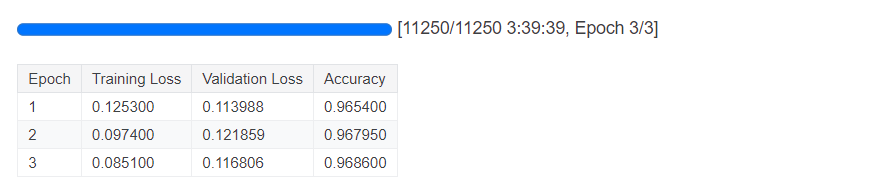

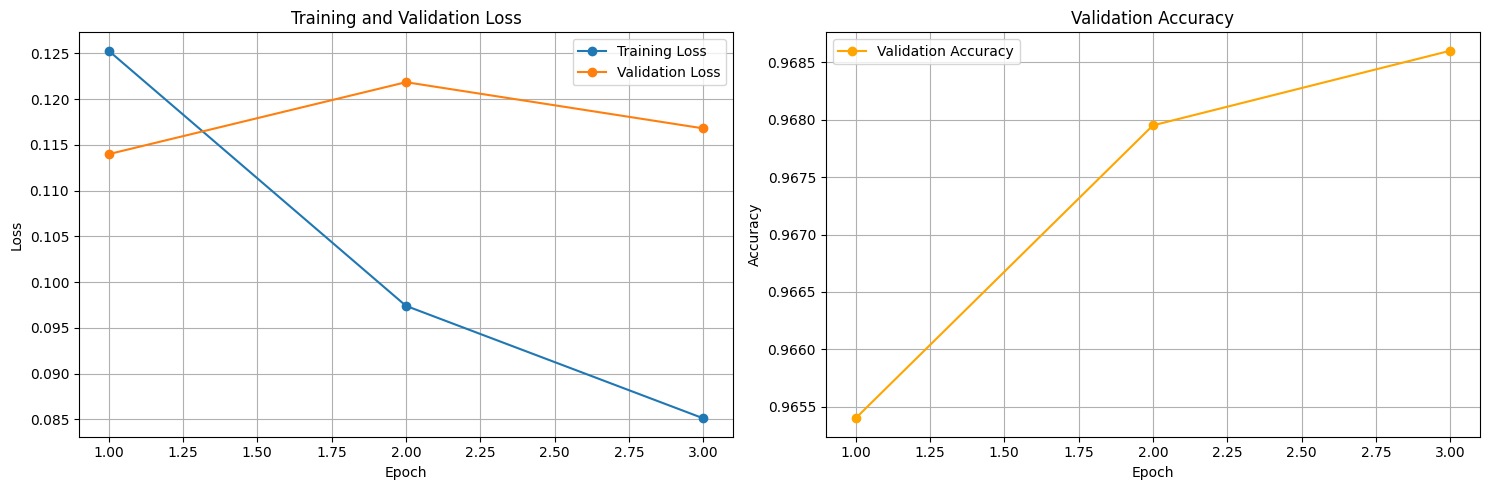

In [76]:
import matplotlib.pyplot as plt

# Dummy data for losses and accuracies
epochs = [1, 2, 3]
train_losses = [0.125300, 0.097400, 0.085100]
val_losses = [0.113988, 0.121859, 0.116806]
val_accuracies = [0.965400, 0.967950, 0.968600]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the loss on the left subplot
axs[0].plot(epochs, train_losses, label='Training Loss', marker='o')
axs[0].plot(epochs, val_losses, label='Validation Loss', marker='o')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].legend()
axs[0].grid(True)

# Plot the accuracy on the right subplot
axs[1].plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Validation Accuracy')
axs[1].legend()
axs[1].grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# # Save the model in safetensors format
# model.save_pretrained('/kaggle/working/xlm-roberta-trained/model', safe_serialization=True)
# # Save the tokenizer (tokenizer save_pretrained doesn't change)
# tokenizer.save_pretrained('/kaggle/working/xlm-roberta-trained/token')

## load trained model

In [132]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
import torch

# Load tokenizer and model from the saved files
model_dir = '/kaggle/input/xlm-ticket-type/pytorch/mymodel/3/results'
tokenizer = XLMRobertaTokenizer.from_pretrained(model_dir)
model = XLMRobertaForSequenceClassification.from_pretrained(model_dir)

## evaluate on val

In [133]:
# Check class balance in test_dataset
val_labels = val_dataset['labels']  # Adjust this if your dataset structure is different
class_balance = pd.Series(val_labels).value_counts()
print("Class Balance in Val Dataset:")
print(class_balance)

Class Balance in Val Dataset:
0    10063
1     9937
Name: count, dtype: int64


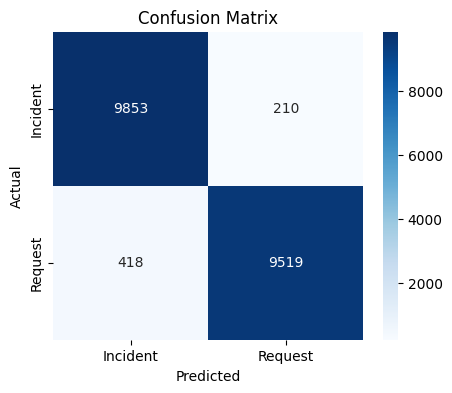

In [134]:
# Set the model to evaluation mode
model.eval()

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Make predictions
predictions = []
true_labels = []

for batch in val_dataset:
    with torch.no_grad():
        inputs = {
            'input_ids': torch.tensor(batch['input_ids']).unsqueeze(0).to(device),
            'attention_mask': torch.tensor(batch['attention_mask']).unsqueeze(0).to(device)
        }
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item()
        
        predictions.append(predicted_class)
        true_labels.append(batch['labels'])

# Convert lists to numpy arrays for easier handling
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Generate classification report
report = classification_report(true_labels, predictions, target_names=['Incident', 'Request'], digits=3)
report

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Incident', 'Request'], yticklabels=['Incident', 'Request'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [136]:
print(report)

              precision    recall  f1-score   support

    Incident      0.959     0.979     0.969     10063
     Request      0.978     0.958     0.968      9937

    accuracy                          0.969     20000
   macro avg      0.969     0.969     0.969     20000
weighted avg      0.969     0.969     0.969     20000



## evaluate on test

In [129]:
# Check class balance in test_dataset
test_labels = test_dataset['labels']  # Adjust this if your dataset structure is different
class_balance = pd.Series(test_labels).value_counts()
print("Class Balance in Test Dataset:")
print(class_balance)

Class Balance in Test Dataset:
1    10035
0     9965
Name: count, dtype: int64


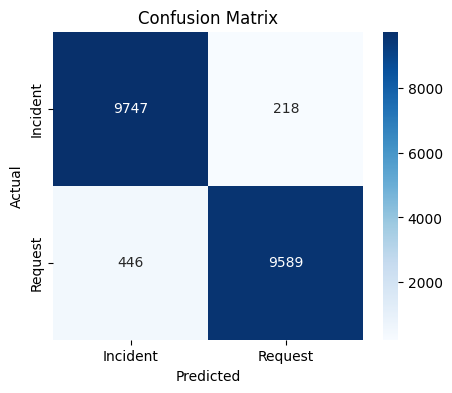

In [137]:
# Set the model to evaluation mode
model.eval()

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Make predictions
predictions = []
true_labels = []

for batch in test_dataset:
    with torch.no_grad():
        inputs = {
            'input_ids': torch.tensor(batch['input_ids']).unsqueeze(0).to(device),
            'attention_mask': torch.tensor(batch['attention_mask']).unsqueeze(0).to(device)
        }
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item()
        
        predictions.append(predicted_class)
        true_labels.append(batch['labels'])

# Convert lists to numpy arrays for easier handling
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Generate classification report
report = classification_report(true_labels, predictions, target_names=['Incident', 'Request'], digits=3)
report

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Incident', 'Request'], yticklabels=['Incident', 'Request'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [138]:
print(report)

              precision    recall  f1-score   support

    Incident      0.956     0.978     0.967      9965
     Request      0.978     0.956     0.967     10035

    accuracy                          0.967     20000
   macro avg      0.967     0.967     0.967     20000
weighted avg      0.967     0.967     0.967     20000



## test 10000 rows

In [111]:
import pandas as pd
import re
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report
import numpy as np

# Load the test dataset
test_df = pd.read_csv('/kaggle/input/testdataframe/dataframe_test.csv', encoding='utf-8')

# Function to extract email subject
def extract_email_subject(text):
    if not isinstance(text, str):
        return ""
    pattern = r"[:\]]\s*(.*)"
    match = re.search(pattern, text)
    return match.group(1).strip() if match else text

# Function to extract email body
def extract_email_body(text):
    if not isinstance(text, str):
        return ""
    body_end_pattern = r"(?i)(\b(best regards|thanks|sincerely|see you soon|regards)\b)"
    match = re.search(body_end_pattern, text)
    if match:
        text = text[:match.start()].strip()
    return text.strip()

# Function to clean text
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|http|<[^>]*>|\S+@\S+|\n+", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.lower().strip()

# Preprocess the test dataset
test_df['clean_subject'] = test_df['subject'].apply(extract_email_subject)
test_df['description'] = test_df['description'].apply(extract_email_body)
test_df['text'] = test_df['clean_subject'] + " " + test_df['description']
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

tokenizer = XLMRobertaTokenizer.from_pretrained(model_dir)
model = XLMRobertaForSequenceClassification.from_pretrained(model_dir)

# Tokenize the cleaned text for prediction
test_encodings = tokenizer(test_df['cleaned_text'].tolist(), truncation=True, padding=True, max_length=512)

# Convert to Hugging Face Dataset format
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
})

# Initialize the trainer
training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=16,
    do_train=False,
    do_eval=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [112]:
# Predict the test dataset
predictions = trainer.predict(test_dataset)

# Convert predictions to labels
pred_labels = np.argmax(predictions.predictions, axis=-1)

# Map predicted labels back to ticket types
id2label = {0: 'Incident', 1: 'Request'}
test_df['predicted_ticket_type'] = [id2label[label] for label in pred_labels]

# Display the resulting DataFrame
# print(test_df[['subject', 'predicted_ticket_type']])

# Generate classification report if true labels are available
if 'ticket_type' in test_df.columns:
    true_labels = test_df['ticket_type'].map(label2id)
    report = classification_report(true_labels, pred_labels, target_names=id2label.values())
    print(report)

# # Optional: Save the DataFrame with predictions to a CSV file
# test_df.to_csv('/kaggle/working/test_predictions.csv', index=False)

              precision    recall  f1-score   support

    Incident       0.97      0.97      0.97      5000
     Request       0.97      0.96      0.97      5000

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [113]:
from sklearn.metrics import classification_report

# Generate classification report if true labels are available
if 'ticket_type' in test_df.columns:
    true_labels = test_df['ticket_type'].map(label2id)
    report = classification_report(true_labels, pred_labels, target_names=id2label.values(), output_dict=True)
    
    # Print the report with 3 decimal places
    report_df = pd.DataFrame(report).T  # Convert to DataFrame
    print(report_df.round(3))  # Round to 3 decimal places


              precision  recall  f1-score    support
Incident          0.965   0.971     0.968   5000.000
Request           0.970   0.965     0.968   5000.000
accuracy          0.968   0.968     0.968      0.968
macro avg         0.968   0.968     0.968  10000.000
weighted avg      0.968   0.968     0.968  10000.000


In [125]:
test_df.columns

Index(['ticket_no', 'subject', 'description', 'ticket_type', 'clean_subject',
       'text', 'cleaned_text', 'predicted_ticket_type'],
      dtype='object')

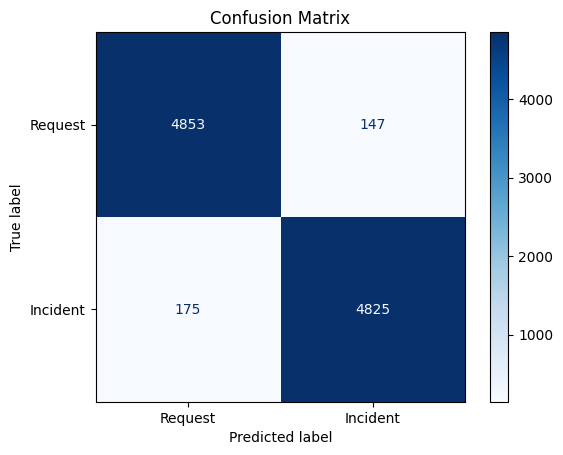

In [126]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming test_df is your DataFrame
true_labels = test_df['ticket_type']
predicted_labels = test_df['predicted_ticket_type']

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_df['ticket_type'].unique())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


## test 200 rows

In [104]:
test_df = pd.read_csv('/kaggle/input/test200/test200.csv', encoding='iso-8859-11')
# test_df = test_df[['Subject','Description']]
test_df.head()

subject  \
0  [Close][OP-NW] INET-INTERNAL [SOC] : ตรวจพบเหต...   
1  [JV-Platform][Softway] : คุณวรเทพ ข้าระบบ Expr...   
2  Interlink  : รบกวนตรวจช่วงเวลา 9.00  10.00 มี...   
3  [Close][OP-SEC]JTEKT ASIA PACIFIC [Pre-sales]:...   
4  NSTDA : NOC ได้รับ Alert [PRD: INET-Log][CNO. ...   

                                         description  
0  From: "servicedesk@inetms.co.th" <servicedesk@...  
1  ชื่อ : วรเทพ  สายสมร\nเบอร์ติดต่อ : 081-868418...  
2  From: NMC Interlinktelecom <p.saowapark@interl...  
3  From: "Nuttapong Inban" <nuttapong.in@inet.co....  
4  From: "Alert INET-Log" <alert-inet-log@inet.co...

In [106]:
import pandas as pd
import re
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report
import numpy as np

# Function to extract email subject
def extract_email_subject(text):
    if not isinstance(text, str):
        return ""
    pattern = r"[:\]]\s*(.*)"
    match = re.search(pattern, text)
    return match.group(1).strip() if match else text

# Function to extract email body
def extract_email_body(text):
    if not isinstance(text, str):
        return ""
    body_end_pattern = r"(?i)(\b(best regards|thanks|sincerely|see you soon|regards)\b)"
    match = re.search(body_end_pattern, text)
    if match:
        text = text[:match.start()].strip()
    return text.strip()

# Function to clean text
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|http|<[^>]*>|\S+@\S+|\n+", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.lower().strip()

# Preprocess the test dataset
test_df['clean_subject'] = test_df['subject'].apply(extract_email_subject)
test_df['description'] = test_df['description'].apply(extract_email_body)
test_df['text'] = test_df['clean_subject'] + " " + test_df['description']
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

tokenizer = XLMRobertaTokenizer.from_pretrained(model_dir)
model = XLMRobertaForSequenceClassification.from_pretrained(model_dir)

# Tokenize the cleaned text for prediction
test_encodings = tokenizer(test_df['cleaned_text'].tolist(), truncation=True, padding=True, max_length=512)

# Convert to Hugging Face Dataset format
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
})

# Initialize the trainer
training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=16,
    do_train=False,
    do_eval=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [108]:
# Predict the test dataset
predictions = trainer.predict(test_dataset)

# Convert predictions to labels
pred_labels = np.argmax(predictions.predictions, axis=-1)

# Map predicted labels back to ticket types
id2label = {0: 'Incident', 1: 'Request'}
test_df['predicted_ticket_type'] = [id2label[label] for label in pred_labels]

test_df[['subject','description', 'predicted_ticket_type']]

subject  \
0    [Close][OP-NW] INET-INTERNAL [SOC] : ตรวจพบเหต...   
1    [JV-Platform][Softway] : คุณวรเทพ ข้าระบบ Expr...   
2    Interlink  : รบกวนตรวจช่วงเวลา 9.00  10.00 มี...   
3    [Close][OP-SEC]JTEKT ASIA PACIFIC [Pre-sales]:...   
4    NSTDA : NOC ได้รับ Alert [PRD: INET-Log][CNO. ...   
..                                                 ...   
195  Supra Foto Elektronik : NOC Monitor พบ Supra F...   
196  [-] BAAC [INEXTBAAC0686 ] : Interlink แจ้งตรวจ...   
197  INET-INTERNAL [SOC] : ตรวจพบเหตุการณ์การเชื่อม...   
198  INETMS : รบกวนยกเลิก Account Email : kasamawat...   
199  Atcetera : แจ้งขอข้อมูล Policy Backup 7 Copy ท...   

                                           description predicted_ticket_type  
0    From: "servicedesk@inetms.co.th" <servicedesk@...              Incident  
1    ชื่อ : วรเทพ  สายสมร\nเบอร์ติดต่อ : 081-868418...              Incident  
2    From: NMC Interlinktelecom <p.saowapark@interl...              Incident  
3    From: "Nuttapong Inban" <nuttapong.in@inet.co....               Request  
4    From: "Alert INET-Log" <alert-inet-log@inet.co...              Incident  
..                                                 ...                   ...  
195  เมื่อเวลา 2024-06-13 20:49:41\n-_INEXT-INEXT_N...              Incident  
196  18:20 LINE Notify BAAC ITEL: INEXTBAAC0686 - C...              Incident  
197  From: "servicedesk@inetms.co.th" <servicedesk@...              Incident  
198  From: Linda Groen <linda.gr@inetms.co.th>\nTo:...               Request  
199  From: Patiphan  Warawattanathamromg <patiphan....               Request  

[200 rows x 3 columns]

In [109]:
test_df[['subject','description', 'predicted_ticket_type']].to_csv('/kaggle/working/test_predictions.csv', index=False)